In [922]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier


RANDOM_STATE = 17

In [923]:
# copy data from text file to local variables
X_train = np.loadtxt(r"c:\Users\litch\HTML\Module19\UCI_HAR_Dataset\train\X_train.txt")

y_train = np.loadtxt(r"c:\Users\litch\HTML\Module19\UCI_HAR_Dataset\train\y_train.txt").astype(int)

X_test = np.loadtxt(r"c:\Users\litch\HTML\Module19\UCI_HAR_Dataset\test\X_test.txt")
y_test = np.loadtxt(r"c:\Users\litch\HTML\Module19\UCI_HAR_Dataset\test\y_test.txt").astype(int)


In [924]:
# convert the raw data to integer values
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [925]:
# convert the raw data to integer values
y_test

array([5, 5, 5, ..., 2, 2, 2])

In [926]:
# Checking dimensions
X_train.shape


(7352, 561)

In [927]:
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [928]:
# Merge X_train with X_test, and y_train with y_test for clustering
#vstack-function is used to stack the sequence of input arrays vertically to make a single array.
#hstack-function is used to stack arrays in sequence horizontally (column wise).
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])


In [929]:
#Define the number of unique values of the labels of the target class
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [930]:
n_classes = np.unique(y).size

In [931]:
#explain the signification of indicators

#1 – marsz (walking)

#2 – wchodzenie po schodach (walking upstairs)

#3 – schodzenie ze schodow (walking downstairs)

#4 – siedzenie (sitting)

#5 – stanie (standing)

#6 – lezenie (laying down)

In [974]:
#scale with standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled

In [933]:
#use the number of dimensions with PCA, leave the maximum number of components to to explain at least 90% of the variance of the (scaled) data 
#Use the scaled dataset and fix random_state(RANDOM_STATE constant)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [934]:
#the minimum number of principal components thet require to cover the 90% of the variance of the original (scaled) data

X_pca.shape


(10299, 65)

In [935]:
#percentage of the variance covered by the first principal component
round(float(pca.explained_variance_ratio_[0] * 100))

51

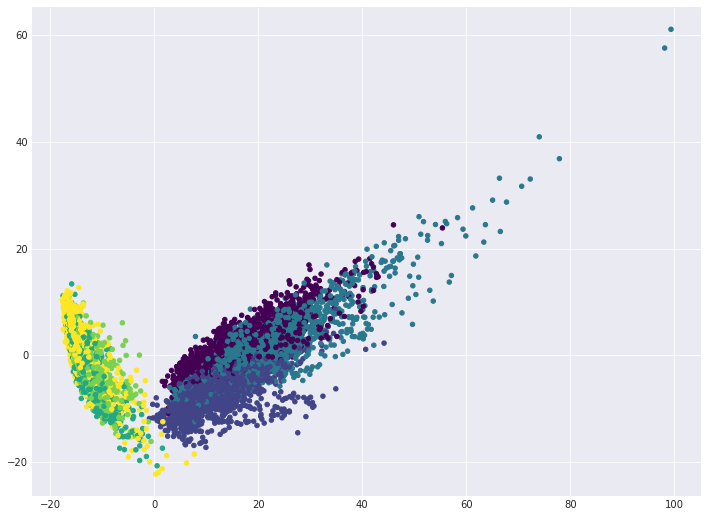

In [936]:
#data visualisation of first 2 principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap="viridis");

In [937]:
#Perform clustering with the KMeans method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

In [938]:
#n_clusters = n_classes (number of unique labels of the target class)

#n_init = 100

#random_state = RANDOM_STATE (for reproducibility of the result)

#Other parameters should have default values.


In [939]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

In [940]:
#Visualize data in projection on the first two principal components

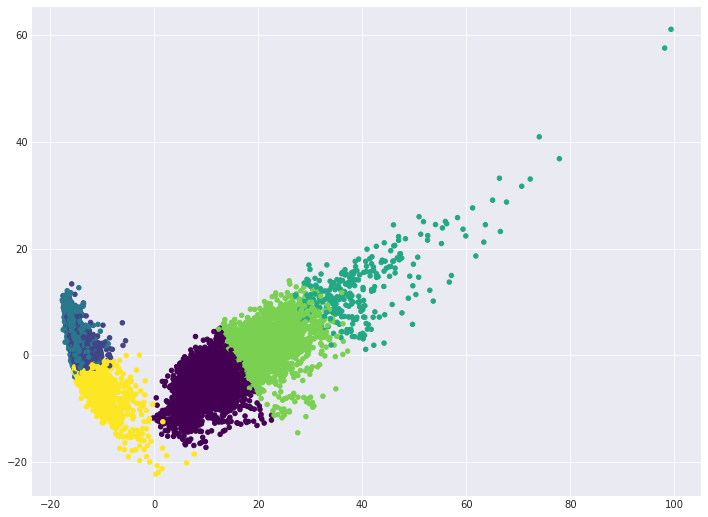

In [941]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap="viridis");

In [942]:

# we can observe the correspondence between the cluster marks and the original class labels and what kinds of activities the KMeans algorithm is confused at.

In [943]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = [
    "marsz",
    "chodzenie po schodach",
    "schodzenie ze schodow",
    "siedzenie",
    "stanie",
    "lezenie",
    "wszystkie czynnosci",
]
tab.columns = ["cluster" + str(i + 1) for i in range(6)] + ["all"]
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
marsz,903,0,0,78,741,0,1722
chodzenie po schodach,1241,0,0,5,296,2,1544
schodzenie ze schodow,320,0,0,196,890,0,1406
siedzenie,1,1235,91,0,0,450,1777
stanie,0,1344,0,0,0,562,1906
lezenie,5,52,1558,0,0,329,1944
wszystkie czynnosci,2470,2631,1649,279,1927,1343,10299


In [944]:
#We see that for each class (i.e., each activity) there are several clusters. 

In [945]:
#This will be a simple metric that characterizes how easily the class is separated from others when clustering.

#Example: if for class “walking downstairs” (with 1406 instances belonging to it), the distribution of clusters is:

#cluster 1 - 900

#cluster 3 - 500

#cluster 6 - 6,

#then such a share will be 900/1406  0.64.

In [946]:
#Function to plot the confusion matrix


In [947]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    ax = plt.gca()
    ax.set_ylim(-.5, 5.5)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [948]:
#aktywność oddzielona od reszty lepiej niż inne na podstawie prostej metryki

pd.Series(
    tab.iloc[:-1, :-1].max(axis=1).values / tab.iloc[:-1, -1].values,
    index=tab.index[:-1],
)

marsz                    0.524390
chodzenie po schodach    0.803756
schodzenie ze schodow    0.633001
siedzenie                0.694992
stanie                   0.705142
lezenie                  0.801440
dtype: float64

In [949]:
# odpowiedz: marsz, stanie, schodzenie ze schodow

In [950]:
#elbow method
#aby wybrać optymalną liczbę klastrów (aby sprawdzić różnicę między zajęciami)
#Parametry algorytmu i wykorzystywane przez nas dane są takie same jak poprzednio, zmieniamy tylko n_clusters

In [951]:

inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(
        X_pca
    )
    inertia.append(np.sqrt(kmeans.inertia_))

  0%|          | 0/6 [00:00<?, ?it/s]

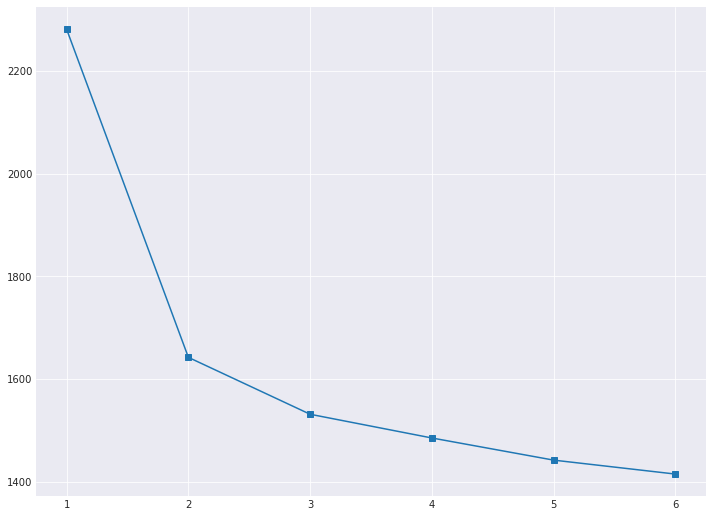

In [952]:
plt.plot(range(1, 7), inertia, marker="s");
plt.show()

In [953]:
#linia znacznie się zmniejsza, aż liczba klastrów wynosi 2, a następnie nie zmienia się już tak bardzo.
#Oznacza to, że optymalna liczba klastrów to 2

In [954]:
# Creating a list labels to be added to plots

labels=['marsz', 'wchodzenie po schodach','schodzenie ze schodow','siedzenie','stanie', 'lezenie']

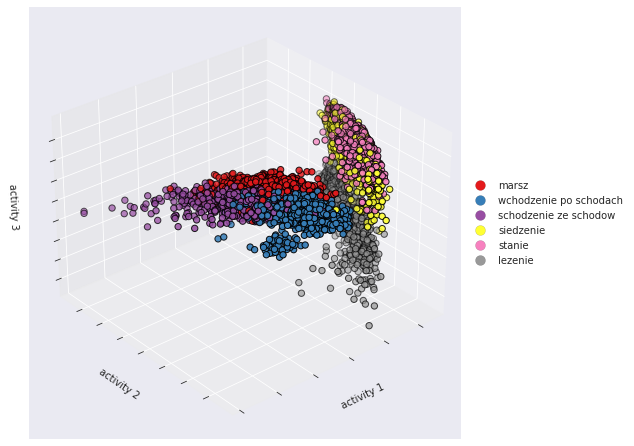

In [955]:
#PCA to sposób na zmniejszenie liczby zmiennych niezależnych w zbiorze danych i ma szczególne zastosowanie, gdy stosunek punktów danych do zmiennych niezależnych .

pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_train)
y = y_train

labels = [('marsz', 1), ('wchodzenie po schodach', 2), ('schodzenie ze schodow', 3), 
          ('siedzenie', 4), ('stanie', 5), ('lezenie', 6)]

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=130)
sc= ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=y, cmap='Set1', edgecolor='k', s=40)

ax.set_xlabel("activity 1")
ax.set_ylabel("activity 2")
ax.set_zlabel("activity 3")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

colors = [sc.cmap(sc.norm(i)) for i in [1,2,3,4,5,6]]
custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
ax.legend(custom_lines, [l[0] for l in labels], 
          loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [956]:
#Mozna zobaczyć 6 dość wyraźnych grup kolorów w 2 głównych skupiskach - 3 warianty chodzenia są blisko siebie, jak można by się spodziewać.
#W większości statyczne działania siedzenie/Stanie/Lezenie są podobnie blisko siebie.

In [957]:
#możliwe byłoby zmniejszenie wymiarowości danych za pomocą PCA

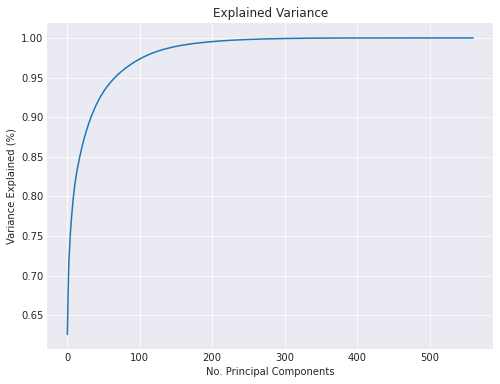

In [958]:

pca = PCA()
X_pca = pca.fit_transform(X_train)

def scree_plot(pca):
    
   #Creates a scree plot associated with the principal components and displays the cumulative variance explained
    
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)

    ax.plot(ind, cumvals)

    ax.set_xlabel("No. Principal Components")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance')
    
scree_plot(pca)

In [959]:
#Komponenty 100 przechwytują ponad 95% wariancji w danych X pociągu. ~200 komponentów wychwytuje prawie 100%.

In [960]:
# Function to plot Confusion Matrix

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [961]:
#ML models
#Generic function to run any model specified
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Reds):
    
# to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    ax = plt.gca()
    ax.set_ylim(-.5,5.5)
    plt.show()
    
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    

    return results
    

In [962]:
# function to define print grid parameters
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))


training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Done 
 

training_time(HH:MM:SS.ms) - 0:00:15.523167


---------------------
|      Accuracy      |
---------------------

    0.9256871394638616


--------------------
| Confusion Matrix |
--------------------

 [[482   8   6   0   0   0]
 [ 46 419   6   0   0   0]
 [ 15  41 364   0   0   0]
 [  0   0   0 435  56   0]
 [  0   0   0  41 491   0]
 [  0   0   0   0   0 537]]


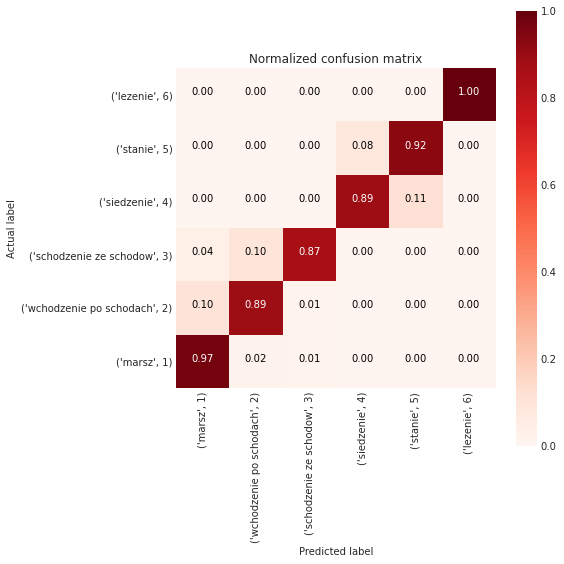

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           1       0.89      0.97      0.93       496
           2       0.90      0.89      0.89       471
           3       0.97      0.87      0.91       420
           4       0.91      0.89      0.90       491
           5       0.90      0.92      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



==> Best Estimator:
	LogisticRegression(C=1)


==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 3

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9374335617559958


In [963]:
#Logistic Regression with Grid Search
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])


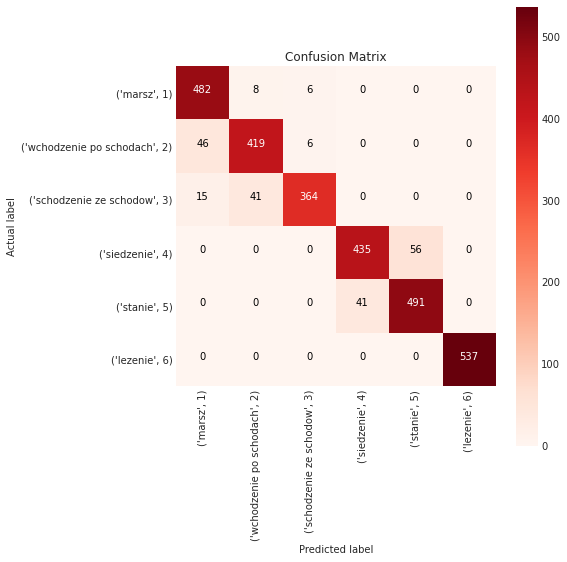

In [964]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Reds, )

plt.show()

In [965]:
# random forest classifier
# set n_estimators to 100. 10 is a bit low, and its been indicated it will change to this in a future version
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())

train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))


Accuracy score TRAIN:  1.0
Accuracy score TEST:  0.9256871394638616


In [966]:
#losowy klasyfikator lasu daje niewielką poprawę dokładności danych testowych do ~92,5%. Ulepszenia w klasyfikacji zarówno chodzenia, jak i czynności statycznych można zaobserwować w macierzy pomyłek.
#Zanotowano 100% dokładność danych pociągu.

In [969]:
#KNN -Mniej skomplikowany model, ale może służyć jako dobry punkt odniesienia. 
#KNN- Powinno działać dość dobrze, biorąc pod uwagę, że te same rodzaje aktywności powinny generować podobne dane sygnałowe
#the KNN to the data 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.ravel())

train_pred = knn.predict(X_train)
y_pred = knn.predict(X_test)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))

Accuracy score TRAIN:  0.9843579978237215
Accuracy score TEST:  0.9015948422124194


In [970]:
#Baseline KNN klasyfikator działał całkiem dobrze z ~90% dokładnością danych testowych.
#Można zaobserwować znaczną utratę dokładności, przechodząc od danych z pociągu do danych testowych, choć jest to uzasadnione, biorąc pod uwagę, że zostały one wygenerowane przez różnych uczestników.
#Macierz pomyłek potwierdza umiarkowaną wydajność we wszystkich 6 rodzajach aktywności.

In [971]:
#the linear SVM classifier
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train.ravel())

train_pred = svc.predict(X_train)
y_pred = svc.predict(X_test)

print('Accuracy score TRAIN: ', format(accuracy_score(y_train, train_pred)))
print('Accuracy score TEST: ', format(accuracy_score(y_test, y_pred)))

Accuracy score TRAIN:  0.9949673558215452
Accuracy score TEST:  0.9660671869697998


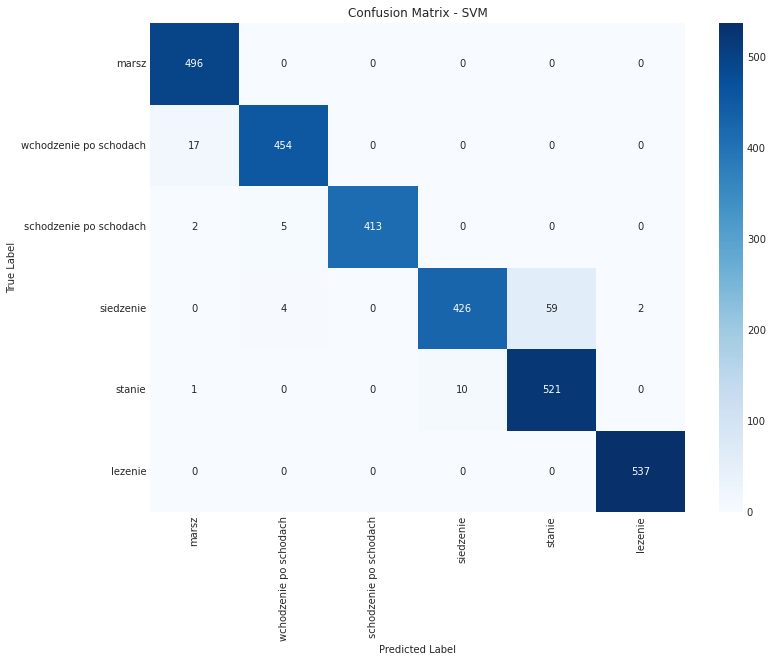

In [972]:
#confusion matrix for Linear SVM
cm = confusion_matrix(y_test, y_pred)

ax = plt.axes()
sns.heatmap(cm, 
            fmt='.0f', 
            annot=True, 
            cmap='Blues',
            xticklabels=['marsz','wchodzenie po schodach','schodzenie po schodach','siedzenie','stanie','lezenie'],
            yticklabels=['marsz','wchodzenie po schodach','schodzenie po schodach','siedzenie','stanie','lezenie'],
            ax = ax)

ax.set_title('Confusion Matrix - SVM')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()



In [ ]:
#SVM z liniowym jądrem daje 96,7% dokładności na danych testowych - całkiem niezła wydajność.
#Macierz pomyłek wskazuje, że nadal istnieje problem z klasyfikacją niektórych czynności siedzących i stojących.
#Rozsądne, aby tak się stało, a naturalna zmienność między sposobem wykonywania czynności przez ludzi może w wiarygodny sposób wyjaśniać różnicę między dokładnością pociągu a dokładnością testu

In [ ]:
#Klasyfikator K-Nearest Neighbors miał najniższą dokładność ~90%
#Support Vector Machine z liniowym jądrem działał najlepiej z dokładnością 96-97%. 
#Przeszukiwanie siatki nie doprowadziło do znaczącej poprawy modelu. Zmniejszenie wymiarowości do 200 głównych komponentów również miało nieznaczny wpływ na dokładność.
#klasyfikator Random Forest podaje dokładność tylko 0,92%
#najlepsze wyniki daje klasyfikacja SVM

In [ ]:
#Różnica między K-Nearest Neighbor (KNN) a K-Means Clustering
#KNN to nadzorowane uczenie maszynowe, podczas gdy K-średnie to nienadzorowane uczenie maszynowe.
#KNN to algorytm uczenia maszynowego klasyfikacji lub regresji, podczas gdy K-średnie to algorytm uczenia maszynowego klastrowania.
#KNN jest leniwym uczniem, podczas gdy K-Means jest chętnym do nauki. 
#Chętny uczeń ma dopasowanie modelu, co oznacza etap szkolenia, ale leniwy uczeń nie ma fazy szkolenia.
#KNN działa znacznie lepiej, jeśli wszystkie dane mają tę samą skalę, ale nie dotyczy to K-średnich
